## Logistic Regression in Plaintext : Training and Evaluation
The file Plaintext_train_eval.ipynb shows the implementation and evaluation of Logistic Regression using Stochastic and Nesterov's Accelereated Gradient method.

We use the the Credit Card Fraud Detection Dataset from Kaggle for this notebook.
Four columns are selected for the model based on the EDA performed in the EDA notebook.

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import sklearn
from sklearn.linear_model import LogisticRegression

## Read data
inputData = pd.read_csv("./creditcard.csv")
data = inputData.iloc[:,[4,10,14,16]]
y = inputData.iloc[:,30] 

data = (data - data.mean())/data.std()


data.iloc[data>2.5] = 2.5

data.describe()

,V4,V10,V14,V16
count,284807.000000,284807.000000,284807.000000,284807.000000
mean,-0.014101,-0.028251,-0.004677,-0.001931
std,0.952832,0.858605,0.983444,0.993073
min,-4.013912,-22.581869,-20.044245,-16.125316
25%,-0.599378,-0.491735,-0.443956,-0.534134
50%,-0.014017,-0.085335,0.052787,0.075792
75%,0.525007,0.416883,0.514450,0.597198
max,2.500000,2.500000,2.500000,2.500000


### Training data preparation

Before running gradient descent, we need to split train-test data, calculate pre-computed weights, and define requred functions.

In [59]:
# Sample Selection

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import NearMiss

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=2)


nm = NearMiss(random_state = 2, sampling_strategy=0.025)
x_res, y_res = nm.fit_resample(X_train, y_train.ravel())

print('Shape of training data after Near Miss: {}'.format(x_res.shape))


x_res = pd.DataFrame(x_res)

# Weights precomputation
# temp = (x_res.loc[y_res==0,:].mean() + x_res.loc[y_res==1,:].mean() )/2

# weight_precomp = [-1*np.log(0.66)/x for x in temp]

# bias = [0.6]

# beta = pd.Series(bias + weight_precomp)

# print(weight_precomp)





Shape of training data after Near Miss: (14678, 4)


In [60]:
## Define Util functions #####


def getLinResponse(train_data, beta):
    
    ## replace with pd dot function
    lin_response = pd.Series(np.dot(train_data, beta))
    return lin_response

def getSigmoid(lin_response):
    
    sigmoid = (1 / (1 + np.exp(-1*(lin_response))))
    return sigmoid



def getBatchGradient(sigmoid, y, train_data):
    
    bg = np.dot((sigmoid-y).T, train_data)
    return bg

def getMomentumGradient(sigmoid, y, train_data, mGradient):
    
    bGradient = getBatchGradient(sigmoid, y, train_data)
    for index in range(len(bGradient)):
        mGradient[index] = ((1 * bGradient[index])/20) + (19 * mGradient[index]/20)
#         mGradient[index] = (bGradient[index]) + (9 * mGradient[index]/10)
    
    return mGradient

def getError(sigmoid, y, t_size):
    
    
    err = np.sum(y*np.log(sigmoid)+(1-y)*np.log(1-sigmoid))/(-1*t_size)  
    
    return err


In [61]:
## Run Gradient Descent with NAG

In [62]:
## Ones column is added to X to account for Bias term in regression

xconst = pd.DataFrame(np.ones(len(x_res)))
train_data = pd.concat([xconst, x_res], axis = 1)


### Initialize weights vector to 0

beta=pd.Series(np.zeros(x_res.shape[1]+1))

starting iter:  0


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log


starting iter:  100
starting iter:  200
starting iter:  300
starting iter:  400
starting iter:  500
starting iter:  600
Error stabilized; Early-Stopping Gradient Descent!


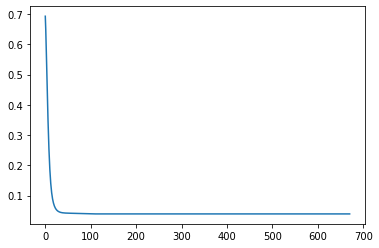

In [63]:
y_res = pd.Series(y_res)


y = y_res
t_size = len(train_data)

iter_num= []
alphaCol = []
error = []

# Stop if error goes below 0.1
thresh = pow(10,-6)

# Stop if not converged in max iterations
max_iter = 1000

alpha = pow(10,-4)

mGradient = np.zeros(len(data.columns)+1)


for i in range(max_iter):
    
    if i%100==0:
        print("starting iter: ", i)
    
    iter_num.append(i)
    alphaCol.append(alpha)
    

    step_temp = pd.Series([val * alpha * -1 for val in mGradient])
    

    beta_temp = beta.add(step_temp)
    

    lin_response = getLinResponse(train_data, beta_temp)


#     sigmoid_l = lsa3Sigmoid(lin_response)
    sigmoid=getSigmoid(lin_response)
    

    mGradient = getMomentumGradient(sigmoid, y, train_data, mGradient)
    

    step = pd.Series([val * alpha * -1 for val in mGradient])
    

    error.append(getError(sigmoid, y, t_size))

    if error[i] < thresh:
    
        print("Converged in iteration: ",i)
        break
    elif i == max_iter-1:
        print("failed to converge in max iterations")
        break
    ## Optional condition for early stopp
    elif i>100:
        if error[i-100]-error[i] < pow(10,-1000) * error[i-100]:
            print("Error stabilized; Early-Stopping Gradient Descent!")
            break
    else:
#         print("update beta with updated step")
        beta = beta.add(step)
        continue

plt.plot(error, label="Error plot by iteration")

## Evaluation on Training Data

The output of the model on training data is simply the sigmoid output for the last iteration of GD.
We apply a threshold as 0.6 (to further reduce False Politives).
This gives the output of the model is {0,1} in the vector 'out'.
This is compared with the training data y vector, y_res, and then accuracy and other metrics are calculated

In [64]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix

out = sigmoid > 0.7
nag_train_accuracy = sum(out == y)/len(y)
nag_train_auc = roc_auc_score(y_res, out)
nag_train_fpr, nag_train_tpr, _ = roc_curve(y_res, sigmoid)
nag_train_precision, nag_train_recall, _ = precision_recall_curve(y_res, sigmoid)
nag_train_mcc = matthews_corrcoef(y_res, out)

tn, fp, fn, tp = confusion_matrix(y_res, out).ravel()
(tn, fp, fn, tp)

(14314, 6, 77, 281)

In [65]:
print(nag_train_accuracy, nag_train_auc, nag_train_mcc)

0.9943452786483172 0.8922486033519552 0.8740131943506709


## Train sklearn Logistic Regression model and calculate metrics.

sklearn model is trained for comparison and evaluation of our algorithm.
The 'liblinear' solver is used, which is considered appropriate for small datasets

In [66]:
clf = LogisticRegression(random_state=42, solver = 'liblinear').fit(x_res, y_res)
y_pred = clf.predict(x_res)
y_pred_prob = clf.predict_proba(x_res)
y_pred_prob = y_pred_prob[:,1]

sk_train_accuracy = clf.score(x_res,y_res)
sk_train_auc = roc_auc_score(y_res, y_pred)
sk_train_fpr, sk_train_tpr, _ = roc_curve(y_res, y_pred_prob)
sk_train_precision, sk_train_recall, _ = precision_recall_curve(y_res, y_pred_prob)
sk_train_mcc = matthews_corrcoef(y_res, y_pred)

In [67]:
sk_train_auc, sk_train_mcc

(0.894622905027933, 0.8590291932201839)

In [68]:
# Evaluate NAG algorithm model for test data

In [69]:
X_test = np.array(X_test)

const1 = np.ones(len(X_test))
const1 = const1.reshape(len(X_test), 1)
test_data = np.concatenate((const1, X_test), axis = 1)

beta_test = [0.49,0.27,-0.12,-0.09,-0.15]
test_resp = getLinResponse(test_data, beta)
test_sig = getSigmoid(test_resp)
test_out = test_sig > 0.6

test_out = np.array(test_out)
y_test = np.array(y_test)


tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, test_out).ravel()
nag_test_accuracy = sum(test_out == y_test)/len(y_test)
nag_test_auc = roc_auc_score(y_test, test_out)
nag_test_mcc = matthews_corrcoef(y_test, test_out)
nag_test_fpr, nag_test_tpr, _ = roc_curve(y_test, test_sig)
nag_test_precision, nag_test_recall, _ = precision_recall_curve(y_test, test_sig)
print(tn_test, fp_test, fn_test, tp_test)

83866 1443 26 108


In [70]:
## Evaluate sklearn model for test data

In [71]:
test_pred = clf.predict(X_test)
test_pred_prob = clf.predict_proba(X_test)
test_pred_prob = test_pred_prob[:,1]

sk_test_accuracy = clf.score(X_test,y_test)
sk_test_auc = roc_auc_score(y_test, test_pred)
sk_test_fpr, sk_test_tpr, _ = roc_curve(y_test, test_pred_prob)
sk_test_precision, sk_test_recall, _ = precision_recall_curve(y_test, test_pred_prob)
sk_test_mcc = matthews_corrcoef(y_test, test_pred)
tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, test_pred).ravel()
print(tn_test, fp_test, fn_test, tp_test)

85285 24 26 108


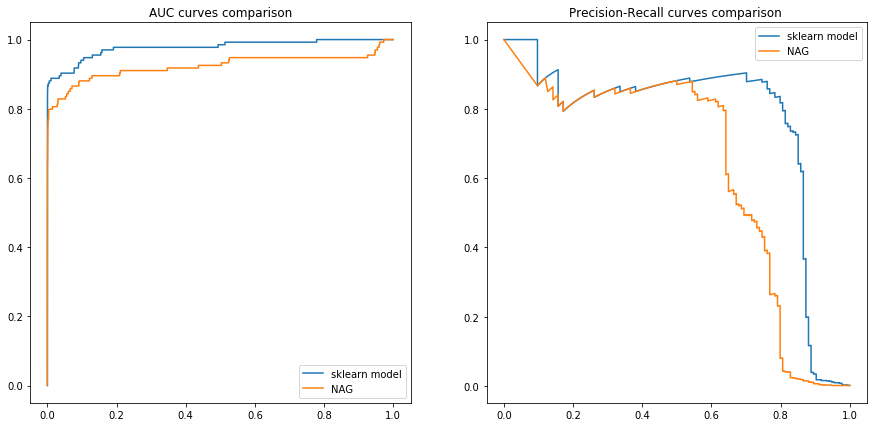

sklearn AUC =  0.90284440951533    NAG AUC =  0.8945275847957811 

sklearn MCC =  0.8117600601574421    NAG MCC =  0.2338788885363971


In [72]:
## Print Evaluation and plot

fig = plt.figure(figsize = (15,7))

plt.subplot(1, 2, 1)
plt.plot(sk_test_fpr,sk_test_tpr, label = 'sklearn model')
plt.plot(nag_test_fpr, nag_test_tpr, label = 'NAG')
plt.legend(loc='best')
plt.title("AUC curves comparison")

plt.subplot(1, 2, 2)
plt.plot(sk_test_recall, sk_test_precision, label = 'sklearn model')
plt.plot(nag_test_recall, nag_test_precision, label = 'NAG')
plt.legend(loc='best')
plt.title("Precision-Recall curves comparison ")
plt.savefig('./sk_nag_evaluation.png', dpi = 100)
plt.show()

print("sklearn AUC = ", sk_test_auc, "   NAG AUC = ", nag_test_auc,"\n")
print("sklearn MCC = ", sk_test_mcc, "   NAG MCC = ", nag_test_mcc)